# MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
# Import mnist dataset using scikit learn.

mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
some_digit = X[0]

In [8]:
some_digit_image = some_digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

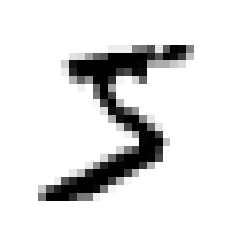

In [9]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [10]:
y[0]

'5'

In [11]:
# Labels are strings - prefer them to be numbers.

import numpy as np
y = y.astype(np.uint8)

In [12]:
# Create a train and test set.

X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Training set is already shuffled - cross-validation folds guaranteed to be similar. Some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row - shuffling the dataset ensures this won't happen.

# Training a Binary Classifier

In [13]:
# Train a classifier to identify the number 5 only.

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Stochastic Gradient Descent (SGD) classifier has the advantage of being able to handle very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (making it suitable for online learning).

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

The SGDClassifier relies on randomness during training. If you want reproducible results, you should set the random_state parameter.

In [15]:
sgd_clf.predict([some_digit]) # Correct result.

array([ True])

# Performance Measures

## Measuring Accuracy using Cross-Validation

**Aside: Implementing Cross-Validation:**

Occasionally, you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. The following code does roughly the same thing as Scikit-Learn's cross_val_score() function, and prints the same result:

In [16]:
# StratifiedKFold provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

C:\Users\Development\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

**Continuing...**

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [18]:
# Comparing this with a classifier that predicts 'Not 5' for every instance:

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()

In [20]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e. when some classes are much more frequent than others).

## Confusion Matrix

The general idea of the confusion matrix is to count the number of times instances of Class A are classified as Class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

Confusion matrix needs a set of predictions to compare against actual targets - use cross_val_predict function (**not the test set**).

In [21]:
# cross_val_predict is same as cross_val_score but returns predictions on each test fold rather than evaluation scores.
# This gives you a clean prediction for each instance in test set - 'clean' meaning the prediction is made by a model
# that never saw the data during training.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in the confusion matrix represents an actual class, while each column represents a predicted class.

The first row of the matrix considers non-5 images (the *negative class*): 53892 of them were correctly classified as non-5s (*true negatives*), while 687 were wrongly classified as 5s (*false positives*).

The second row considers the images of 5s (the *positive class*): 1891 were wrongly classified as non-5s (*false negatives*) and 3530 were correctly classified as 5s (*true positives*).

In [23]:
# Perfect classifier only has non-zero elements on diagonal of confusion matrix:

y_train_perfect_pred = y_train_5 # pretend we reached perfection.
confusion_matrix(y_train_5,y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

A more concise metric is the accuracy of the positive predictions, this is called the *precision* of the classifier:

precision = $\frac{TP}{TP+FP}$

*TP* is the number of true positives, *FP* is the number of false positives.

Precision is typically used along with another metric called *recall*, also called *sensitivity* or the *true positive rate*: this is the ratio of positive instances that are correctly detected by the classifier.

recall = $\frac{TP}{TP+FN}$

*FN* is false negatives.

## Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Classifier is only correct for 83.7% of its '5' predictions, and only detects 65.1% of 5s.

The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high. Useful for comparing classifiers.

F1 = $\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$ = 2 x $\frac{precision  *  recall}{precision + recall}$

F1 = $\frac{TP}{TP + \frac{FN+FP}{2}}$

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favours classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. See book for examples.

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice-versa. This is called the *precision/recall trade-off*.

## Precision/Recall Trade-off

Sci-kit learn gives access to the decision scores that it uses to make predictions. Instead of calling the classifiers predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # Raising threshold decreases recall.

array([False])

**How do you decide which threshold to use?** First, use cross_val_predict() function to get scores of all instances in training set:

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [31]:
# Use precision_recall_curve() function to compute precision and recall for all possible thresholds:

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

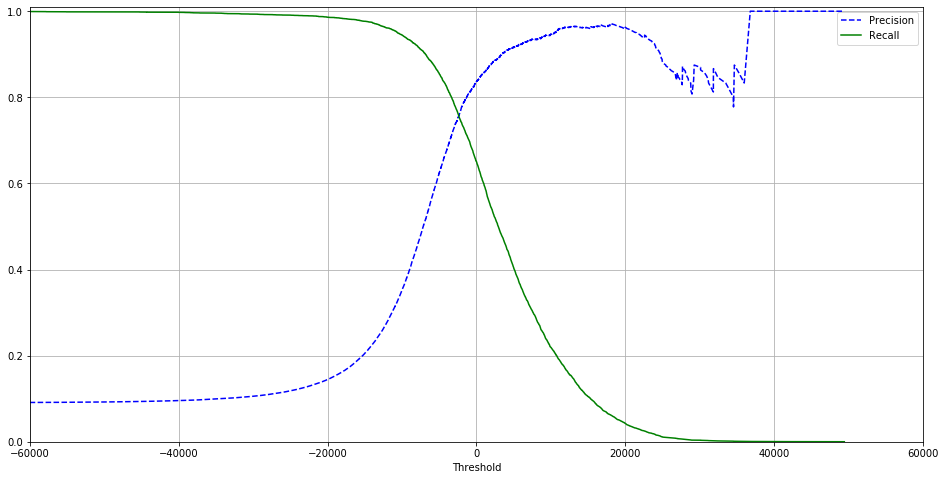

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16,8))
    plt.plot(thresholds, precisions[:-1],'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xticks([-60000, -40000, -20000, 0, 20000, 40000, 60000])
    plt.xlim([-60000,60000])
    plt.ylim([0,1.01])
    plt.xlabel('Threshold')
    plt.grid()
    plt.legend()
    

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

Precision curve is bumpy because precision sometimes decreases when the threshold is raised. Recall can only go down when the threshold is increased, which explains the smooth curve.

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

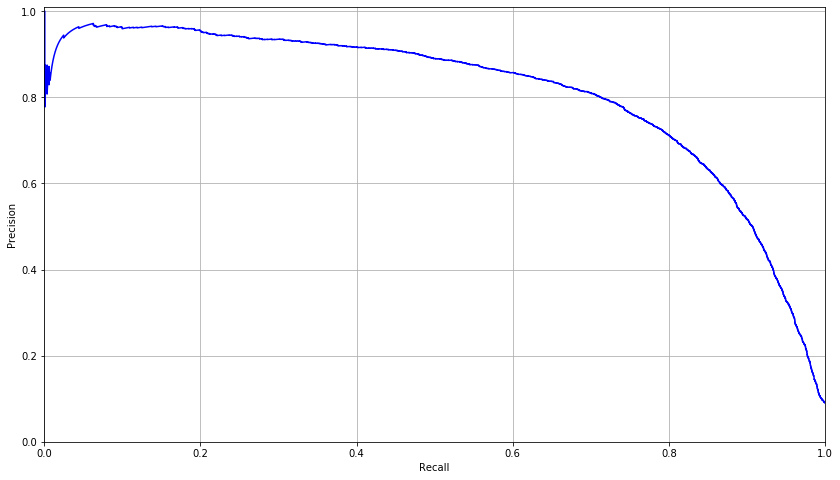

In [33]:
plt.figure(figsize=(14,8))
plt.plot(recalls[:-1], precisions[:-1],'b-')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim([0.,1.])
plt.ylim([0,1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

In [34]:
# Need to search for lowest threshold that gives at least 90% precision.
# Can use np.argmax() to give you the first index of the maximum value, which in this case is boolean True:

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

**If someone says, "Let's reach 99% precision", you should ask, "At what recall?".**

## The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR).

FPR = $\frac{FP}{FP+TN}$

or

FPR = $1 - \frac{TN}{FP+TN}$ 

where $\frac{TN}{FP+TN}$ is the *true negative rate* (TNR). The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) against 1 - *specificity*.



In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

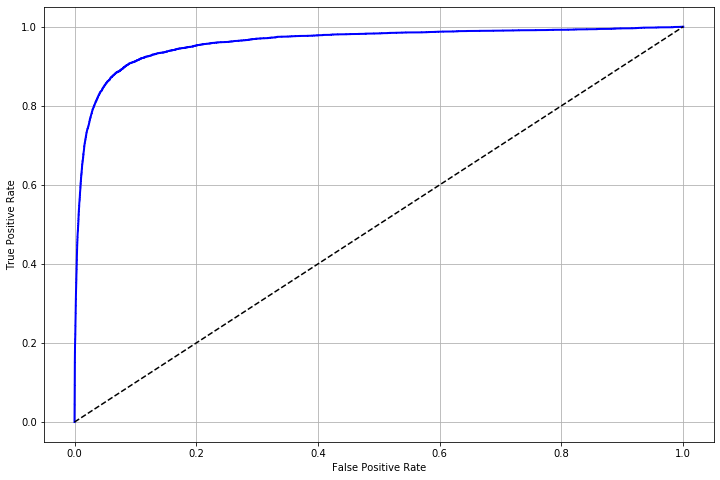

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, 'b-', linewidth='2', label=label)
    plt.plot([0,1],[0,1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()

plt.figure(figsize=(12,8))
plot_roc_curve(fpr,tpr)

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top left corner).

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC of 1, whereas a purely random classifier will have a ROC AUC of 0.5:

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top left corner).

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# RandomForestClassifier does not have decision_function() method - has predict_proba() method instead. sklearn classifiers
# generally have 1 or the other, or both.
# The predict_proba() method returns an array containg a row per instance and a column per class, each containing the
# probability that the given instance belongs to the given class.

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [42]:
y_scores_forest = y_probas_forest[:,1] # Score = probability of positive class.
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5, y_scores_forest)

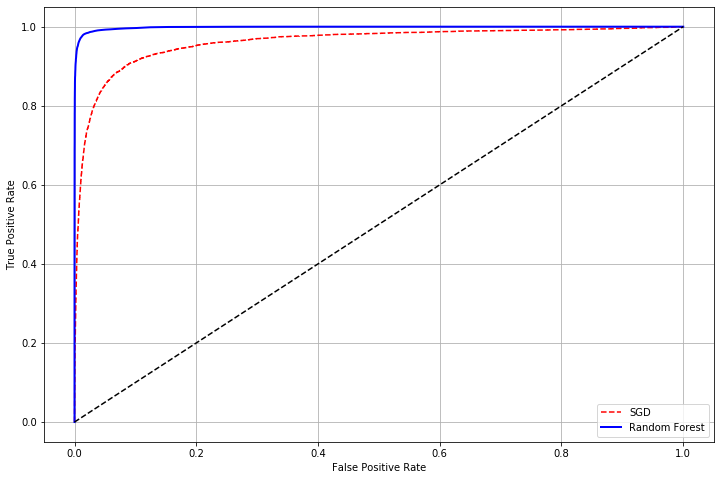

In [43]:
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,'r--',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
forest_train_preds = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [46]:
precision_score(y_train_5, forest_train_preds)

0.9905083315756169

In [47]:
recall_score(y_train_5,forest_train_preds)

0.8662608374838591

# Multiclass Classification

In [48]:
# scikit learn auto detects when you try to use a binary classifier for a multiclass classification problem, and automatically
# runs OvO or OvR, depending on the algorithm.

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, sci-kit learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores # 1 score per class.

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
svm_clf.classes_[5]

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class in classes_ array conveniently matches the class itself, but in general you won't be so lucky.

If you want to force sklearn to use OvO or OvR, you can use the OneVsOneClassifier or OneVsRestClassifier classes:

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

In [55]:
# Training and SGD classifier is just as easy:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

For SGDClassifier, sklearn did not have to run OvO or OvR as SGD classifiers can directly classify instances into multiple classes.

In [57]:
sgd_clf.decision_function([some_digit])

array([[-23345.29341959, -30863.79988234,  -8289.70393964,
          3253.44722101, -28708.64810574,    128.16902097,
        -37196.63320674, -12558.47857139, -11810.94737203,
         -7010.84915405]])

In [58]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy') # Evaluate SGDClassifier's accuracy

array([0.8513 , 0.87925, 0.8465 ])

In [59]:
# Scaling the inputs improves accuracy:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_fl64 = X_train.astype(np.float64)
scaler.fit(X_train_fl64)
X_train_scaled = scaler.transform(X_train_fl64)
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

C:\Users\Development\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90155, 0.89455, 0.9064 ])

# Error Analysis

Normally follow ML project checklist, here we assume a promising model has ben found and you are looking for ways to improve it. One way to do this is to analyze the types of errors it makes.

First, look at the confusion matrix:

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\Development\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5588,    0,   21,    6,    8,   48,   37,    6,  208,    1],
       [   1, 6411,   38,   24,    4,   45,    4,    8,  194,   13],
       [  27,   27, 5266,   98,   73,   28,   66,   38,  323,   12],
       [  25,   19,  120, 5251,    2,  214,   27,   43,  359,   71],
       [  12,   14,   48,   12, 5214,   13,   39,   26,  291,  173],
       [  27,   16,   30,  176,   54, 4500,   79,   17,  459,   63],
       [  30,   15,   44,    2,   42,   99, 5565,    4,  116,    1],
       [  20,   10,   54,   28,   52,   14,    3, 5711,  162,  211],
       [  19,   66,   48,   89,    3,  122,   28,   11, 5419,   46],
       [  23,   21,   29,   65,  117,   39,    1,  182,  314, 5158]],
      dtype=int64)

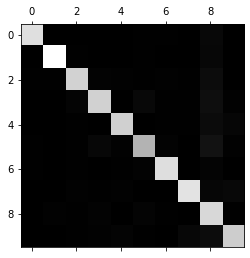

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [62]:
import pandas as pd

df = pd.DataFrame(y_train, columns =['y_train'])

In [63]:
distrib = df['y_train'].value_counts().sort_index()
distrib

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: y_train, dtype: int64

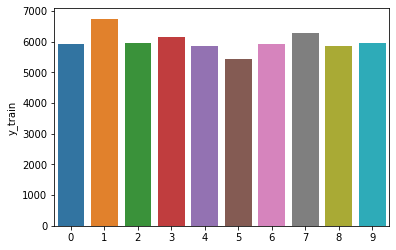

In [64]:
import seaborn as sns
sns.barplot(distrib.index,distrib)

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [66]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.43440824e-01, 0.00000000e+00, 3.54550059e-03, 1.01300017e-03,
        1.35066689e-03, 8.10400135e-03, 6.24683437e-03, 1.01300017e-03,
        3.51173392e-02, 1.68833361e-04],
       [1.48323939e-04, 9.50904776e-01, 5.63630970e-03, 3.55977455e-03,
        5.93295758e-04, 6.67457728e-03, 5.93295758e-04, 1.18659152e-03,
        2.87748443e-02, 1.92821121e-03],
       [4.53172205e-03, 4.53172205e-03, 8.83853642e-01, 1.64484726e-02,
        1.22524337e-02, 4.69956361e-03, 1.10775428e-02, 6.37797919e-03,
        5.42128231e-02, 2.01409869e-03],
       [4.07763823e-03, 3.09900506e-03, 1.95726635e-02, 8.56467134e-01,
        3.26211059e-04, 3.49045833e-02, 4.40384929e-03, 7.01353776e-03,
        5.85548850e-02, 1.15804926e-02],
       [2.05409106e-03, 2.39643958e-03, 8.21636426e-03, 2.05409106e-03,
        8.92502568e-01, 2.22526532e-03, 6.67579596e-03, 4.45053064e-03,
        4.98117083e-02, 2.96131462e-02],
       [4.98063088e-03, 2.95148497e-03, 5.53403431e-03, 3.24663346e-02,
   

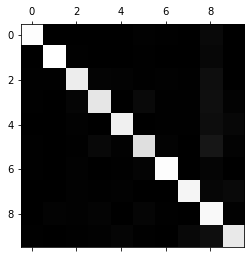

In [67]:
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)

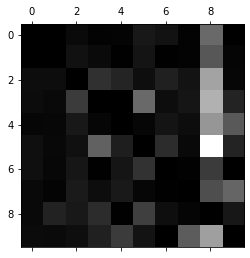

In [68]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)

In [69]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

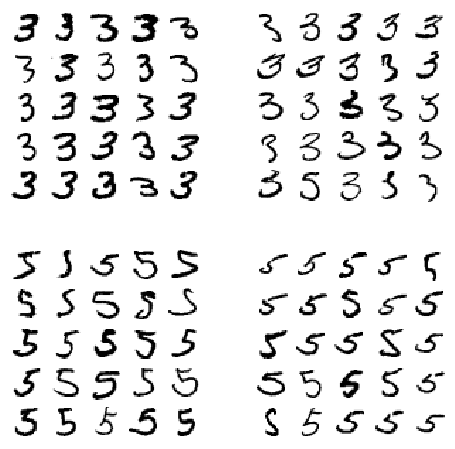

In [70]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

A classification system that outputs multiple binary tags is called a multilabel classification system.

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

Selecting the right performance metric for a multilabel classifier depends on the project. One approach is to measure the F1 score for each label then compute the average score.

In [73]:
# Commented out line below takes hours to run:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
y_train_knn_pred = cross_val_predict(knn_clf, X_train[:3500], y_multilabel[:3500], cv=3)

In [74]:
f1_score(y_multilabel[:3500], y_train_knn_pred, average='macro') # Not realistic as we didn't use full training set.
# Actual score is ~0.976.

0.9346591327143392

This assumes that all labels are equally important, however which may not be the case. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average = 'weighted' in the preceding code - few other averaging options and multilabel classifier metrics available with sklearn.

# Multioutput Classification

Multioutput multiclass classification (or simply multioutput classification) is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than 2 possible values).

The line between classification and regression is sometimes blurry, such as in the following example. Arguably, predicting pixel intensity is more akin to regression than classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.

In [75]:
# Add noise to pixel intensities of MNIST images using np.randint() function:
noise = np.random.randint(0,100, (len(X_train),784))
X_train_mod = X_train + noise

noise = np.random.randint(0,100, (len(X_test),784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [76]:
knn_clf.fit(X_train_mod,y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

(-0.5, 27.5, 27.5, -0.5)

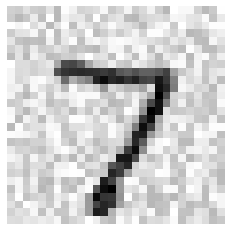

In [77]:
plt.imshow(X_test_mod[0].reshape(28,28), cmap='binary')
plt.axis('off')

In [78]:
clean_digit = knn_clf.predict([X_test_mod[0]])

(-0.5, 27.5, 27.5, -0.5)

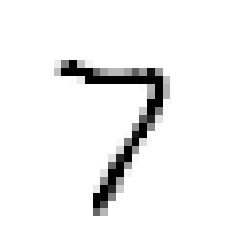

In [79]:
plt.imshow(clean_digit.reshape(28,28), cmap='binary')
plt.axis('off')

# Exercises

## Exercise 1

In [80]:
from sklearn.model_selection import GridSearchCV

knn_clf_ex = KNeighborsClassifier()

param_grid = [
    {'weights':['uniform','distance'],'n_neighbors':[4,5,6]}
]

grid_search = GridSearchCV(knn_clf_ex, param_grid, cv=3,scoring='accuracy',
                          return_train_score=False,verbose=3)
grid_search.fit(X_train_scaled,y_train)
grid_search.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=4, weights=uniform, score=0.935, total=20.1min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.1min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.939, total=21.7min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 41.8min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.938, total=18.5min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.943, total=19.3min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.944, total=17.8min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.944, total=18.1min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.938, total=16.8min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.941, total=18.0min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.942, total=19.7min
[CV] n_neighbors=5, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 323.5min finished


{'n_neighbors': 4, 'weights': 'distance'}

In [81]:
knn_model = grid_search.best_estimator_

In [82]:
X_test_prepared = scaler.transform(X_test.astype(np.float64))

In [83]:
from sklearn.metrics import accuracy_score

y_test_pred = knn_model.predict(X_test_prepared)

accuracy_score(y_test, y_test_pred)

0.9489

In [84]:
import joblib

joblib.dump(knn_model,'models/mnist_knn_classifier.pkl')
joblib.dump(scaler,'models/mnist_scaler.pkl')

['models/mnist_scaler.pkl']

In [85]:
import csv

with open('models/knn_mnist_params.csv', 'w') as f:
    for key in grid_search.best_params_.keys():
        f.write("%s,%s\n"%(key,grid_search.best_params_[key]))

**Continuing Exercise 2 in another notebook - don't want to have to rerun this entire notebook again.**